# Lecture 10: Classification with Multilayer Perceptron

Dataset used: [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

### Loading saved features

In [4]:
with open("trainFeats.pckl", "rb") as f:
    trainFeats = pickle.load(f)
with open("trainLabel.pckl", "rb") as f:
    trainLabel = pickle.load(f)
    
with open("testFeats.pckl", "rb") as f:
    testFeats = pickle.load(f)
with open("testLabel.pckl", "rb") as f:
    testLabel = pickle.load(f)

### Defining network architecture

In [5]:
class mlp(nn.Module):
    def __init__(self,n_channels): #n_channels => length of feature vector
        super(mlp, self).__init__()
        self.L1 = nn.Linear(n_channels,6) #Mapping from input to hidden layer       
        self.L2 = nn.Linear(6,10) #Mapping from hidden layer to output
    def forward(self,x): #x => Input
        x = self.L1(x) #Feed-forward  
        x = F.relu(x) #Sigmoid non-linearity
        x = self.L2(x) #Feed-forward           
        x = F.softmax(x) #Sigmoid non-linearity
        return x

### Dataset preparation

In [6]:
# Generating 1-hot label vectors
trainLabel2 = np.zeros((50000,10))
testLabel2 = np.zeros((10000,10))
for d1 in range(trainLabel.shape[0]):
    trainLabel2[d1,trainLabel[d1]] = 1
for d2 in range(testLabel.shape[0]):
    testLabel2[d2,testLabel[d2]] = 1

In [7]:
# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel2))
# Creating dataloader
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)

In [8]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()

### Defining function for training the network 

In [14]:
# Definining the training routine
def train_model(model,criterion,num_epochs,learning_rate):
        start = time.time()
        train_loss = [] #List for saving the loss per epoch     
        
        for epoch in range(num_epochs):
            epochStartTime = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))

            running_loss = 0.0           
            # Loading data in batches
            batch = 0
            for data in trainLoader:
                inputs,labels = data
                # Wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.float().cuda()), \
                        Variable(labels.float().cuda())
                else:
                    inputs, labels = Variable(inputs.float()), Variable(labels.float())    
                # Initializing model gradients to zero
                model.zero_grad() 
                # Data feed-forward through the network
                outputs = model(inputs)
                # Predicted class is the one with maximum probability
                _, preds = torch.max(outputs.data, 1)
                # Finding the MSE
                loss = criterion(outputs, labels)
                # Accumulating the loss for each batch
                #running_loss += loss.data[0]
                running_loss +=loss.data
                # Backpropaging the error
                if batch == 0:
                    totalLoss = loss
                    totalPreds = preds
                    batch += 1                    
                else:
                    totalLoss += loss
                    totalPreds = torch.cat((totalPreds,preds),0)  
                    batch += 1
                    
            totalLoss = totalLoss/batch
            totalLoss.backward()
            
            # Updating the model parameters
            for f in model.parameters():
                f.data.sub_(f.grad.data * learning_rate)                
           
            epoch_loss = running_loss/50000  #Total loss for one epoch
            train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph           
            
            print('Epoch loss: {:.6f}'.format(epoch_loss))
            epochTimeEnd = time.time()-epochStartTime
            print('Epoch complete in {:.0f}m {:.0f}s'.format(
            epochTimeEnd // 60, epochTimeEnd % 60))
            print('-' * 25)
            # Plotting Loss vs Epochs
            fig1 = plt.figure(1)        
            plt.plot(range(epoch+1),train_loss,'r--',label='train')        
            if epoch==0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
            fig1.savefig('mlp_lossPlot.png')             

        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        return model

### Model initialization and training

Epoch 0/19


C:\Users\asrivastava01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Epoch loss: 0.001419
Epoch complete in 0m 5s
-------------------------
Epoch 1/19
Epoch loss: 0.001418
Epoch complete in 0m 6s
-------------------------
Epoch 2/19
Epoch loss: 0.001417
Epoch complete in 0m 7s
-------------------------
Epoch 3/19
Epoch loss: 0.001416
Epoch complete in 0m 7s
-------------------------
Epoch 4/19
Epoch loss: 0.001416
Epoch complete in 0m 7s
-------------------------
Epoch 5/19
Epoch loss: 0.001415
Epoch complete in 0m 7s
-------------------------
Epoch 6/19
Epoch loss: 0.001415
Epoch complete in 0m 8s
-------------------------
Epoch 7/19
Epoch loss: 0.001414
Epoch complete in 0m 7s
-------------------------
Epoch 8/19
Epoch loss: 0.001414
Epoch complete in 0m 7s
-------------------------
Epoch 9/19
Epoch loss: 0.001413
Epoch complete in 0m 6s
-------------------------
Epoch 10/19
Epoch loss: 0.001413
Epoch complete in 0m 6s
-------------------------
Epoch 11/19
Epoch loss: 0.001413
Epoch complete in 0m 7s
-------------------------
Epoch 12/19
Epoch loss: 0

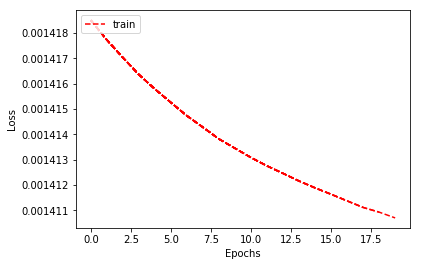

In [15]:
feat_length = 2+5+2
model = mlp(feat_length) # Initilaizing the model
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=20,learning_rate=10) # Training the model

### Evaluation of trained model

In [17]:
# Finding testing accuracy
test_running_corr = 0
# Loading data in batches
batches = 0
for tsData in testLoader:
    inputs,labels = tsData
    # Wrap them in Variable
    if use_gpu:
        inputs, labels = Variable(inputs.float().cuda()), \
            Variable(labels.float().cuda())
    else:
        inputs, labels = Variable(inputs.float()), Variable(labels.float())        
    # Feedforward train data batch through model
    output = model(inputs) 
    # Predicted class is the one with maximum probability
    _,preds = output.data.max(1)    
    if batches==0:
        totalPreds = preds
        batches = 1
    else:
        totalPreds = torch.cat((totalPreds,preds),0)

ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),testLabel))
ts_acc = ts_corr/10000.0
print('Testing accuracy = '+str(ts_acc))

C:\Users\asrivastava01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Testing accuracy = 0.0


**Need to improve testing accuracy.**